In [ ]:
!pip install ultralytics opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [ ]:
import cv2
import os
from pathlib import Path
from ultralytics import YOLO

# Mount dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### One time setup -- to unzip processed files accordingly into Colab

In [ ]:
from google.colab import files
import zipfile
import os

# Upload a zipped folder (train.zip or val.zip)
uploaded = files.upload()

# # Unzip it into the right folder
# with zipfile.ZipFile("train.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/images/")

with zipfile.ZipFile("val.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/images/")


Saving val.zip to val.zip


In [ ]:
from google.colab import files
import zipfile
import os

# Upload zipped label folders (train.zip, val.zip)
uploaded = files.upload()  # choose both train.zip and val.zip

# Define your base path
base_dir = "/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/labels/"

# # Unzip train labels
# with zipfile.ZipFile("train.zip", 'r') as zip_ref:
#     zip_ref.extractall(base_dir)

# Unzip val labels
with zipfile.ZipFile("val.zip", 'r') as zip_ref:
    zip_ref.extractall(base_dir)

print("✅ Labels unzipped to:", base_dir)
print("Folders:", os.listdir(base_dir))


Saving val.zip to val.zip
✅ Labels unzipped to: /content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/labels/
Folders: ['train', 'val']


### Apply CLAHE Processing to pictures

In [ ]:
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm")

def clahe_img(img):
    # convert to LAB and apply CLAHE on L channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)



# Apply CLAHE and save the processed
def apply_clahe(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for file in os.listdir(input_dir):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = Path(input_dir)/file
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            img_out = clahe_img(img)
            cv2.imwrite(str(Path(output_dir)/file), img_out)

apply_clahe(BASE_DIR/"images/train", BASE_DIR/"images/train_clahe")
apply_clahe(BASE_DIR/"images/val", BASE_DIR/"images/val_clahe")

In [ ]:
import yaml
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm")

yaml_dict = {
    "path": "/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm",
    "train": "images/train_clahe",
    "val": "images/val_clahe",
    "test": "images/test_clahe",
    "nc": 2,
    "names": ["benign", "malignant"]
}

with open("/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml", "w") as f:
    yaml.dump(yaml_dict, f)


print("Created:", BASE_DIR/"cbis_ddsm_clahe.yaml")


Created: /content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml


In [ ]:
# Check if labels are present
!ls "/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/labels/val_clahe" | head

1-004.txt
1-005.txt
1-010.txt
1-014.txt
1-015.txt
1-017.txt
1-018.txt
1-020.txt
1-021.txt
1-024.txt


In [ ]:
# Proposed yolov5 small model
from ultralytics import YOLO

model = YOLO("yolov5s.yaml")
model.train(
    data="/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml",
    imgsz=640,
    epochs=100,
    batch=16,
    # device=0,
    project="/content/drive/MyDrive/Prototype - Copy/runs_ultralytics",
    name="cbis_clahe_scratch",
    save_period=10
)


Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=cbis_clahe_scratch4, nbs=64, nms=False, opset=None, optimize=False, optimiz

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7986db8b6db0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Small model but 200 epochs
from ultralytics import YOLO

model = YOLO("yolov5s.yaml")

model.train(
    data="/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml",
    imgsz=640,
    epochs=200,
    batch=16,
    project="/content/drive/MyDrive/Prototype - Copy/runs_ultralytics",
    name="cbis_clahe_s(200)",
    exist_ok = True,
    save_period=10
)


Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=cbis_clahe_s(200), nbs=64, nms=False, opset=None, optimize=False, optimizer=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9505a57980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

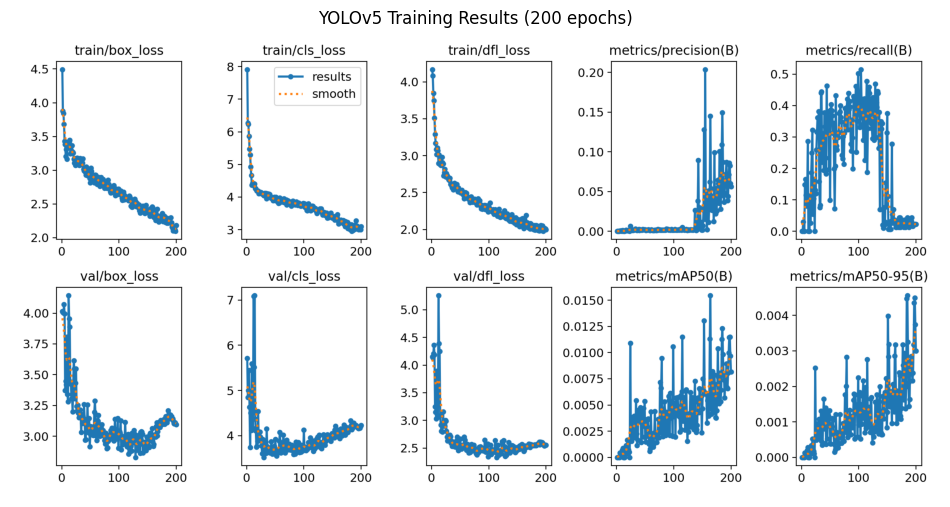

In [17]:
import cv2
import matplotlib.pyplot as plt

# Path to the results.png of yolov5s (200 epochs)
img_path = "/content/drive/MyDrive/Prototype - Copy/runs_ultralytics/cbis_clahe_s(200)/results.png"

# Load and display
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis("off")
plt.title("YOLOv5 Training Results (200 epochs)")
plt.show()


In [18]:
# yolov8 model
from ultralytics import YOLO

model = YOLO("yolov8s.yaml")

model.train(
    data="/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml",
    imgsz=640,
    epochs=100,
    batch=16,
    project="/content/drive/MyDrive/Prototype - Copy/runs_ultralytics",
    name="v8_cbis_clahe_s(200)",
    exist_ok = True,
    save_period=10
)


Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm/cbis_ddsm_clahe.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=v8_cbis_clahe_s(200), nbs=64, nms=False, opset=None, optimize=False, optimiz

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9543ce3e30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

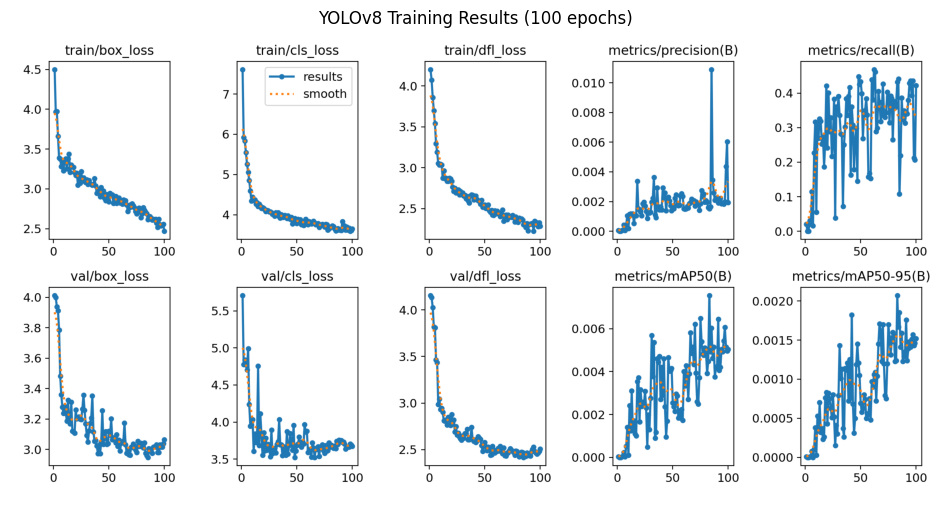

In [19]:
import cv2
import matplotlib.pyplot as plt

# Plot yolov8 results
img_path = "/content/drive/MyDrive/Prototype - Copy/runs_ultralytics/v8_cbis_clahe_s(100)/results.png"

# Load and display results
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.title("YOLOv8 Training Results (100 epochs)")
plt.show()


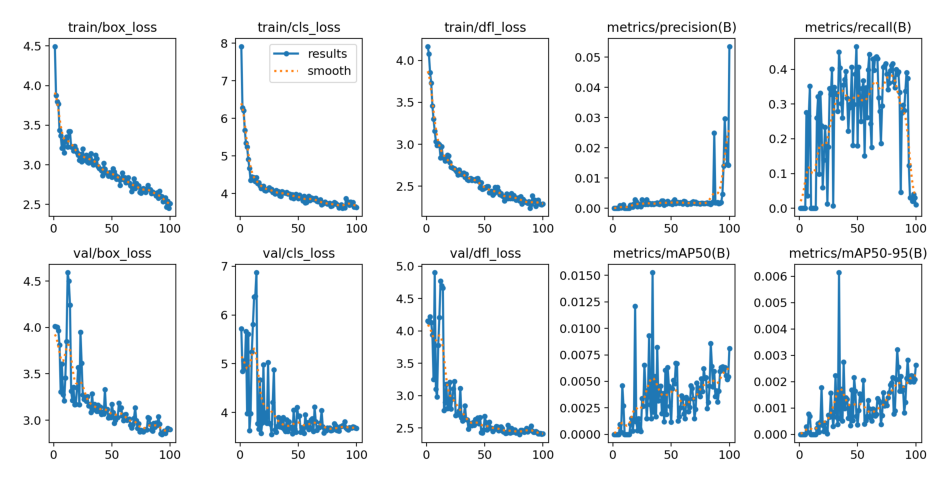

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the saved results.png (yolov5s, 100 epochs)
img_path = "/content/drive/MyDrive/Prototype - Copy/runs_ultralytics/cbis_clahe_scratch4/results.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
import pandas as pd

# Load results.csv for yolov5s (100)
csv_path = "/content/drive/MyDrive/Prototype - Copy/runs_ultralytics/cbis_clahe_scratch4/results.csv"
df = pd.read_csv(csv_path)

# Find best mAP50 and mAP50-95
best_map50 = df["metrics/mAP50(B)"].max()
best_map5095 = df["metrics/mAP50-95(B)"].max()

# Find the epoch where they occurred
best_epoch_map50 = df["metrics/mAP50(B)"].idxmax()
best_epoch_map5095 = df["metrics/mAP50-95(B)"].idxmax()

print(f"Best mAP50: {best_map50:.4f} at epoch {best_epoch_map50}")
print(f"Best mAP50-95: {best_map5095:.4f} at epoch {best_epoch_map5095}")


Best mAP50: 0.0153 at epoch 33
Best mAP50-95: 0.0061 at epoch 33


Image: 1-148.jpg
Label: 1-148.txt
Box: (2472, 2952), (3497, 4121)


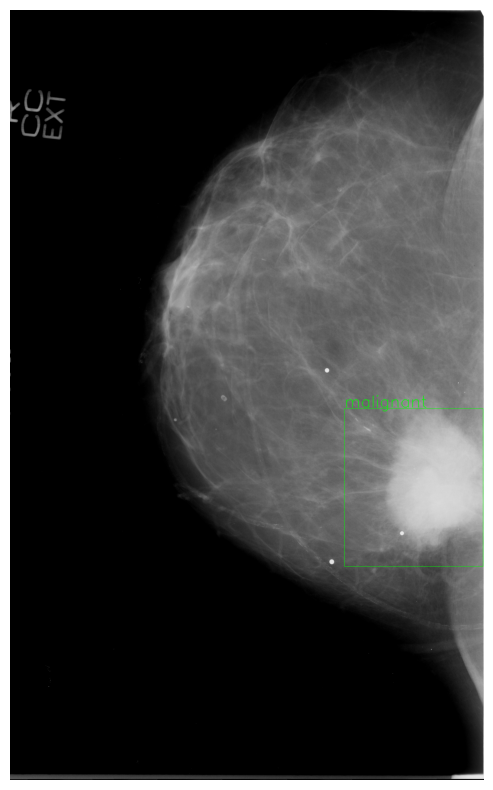

In [ ]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
BASE_DIR = Path("/content/drive/MyDrive/Prototype - Copy/yolo_cbis_ddsm")
# Random image chosen: 1-148
img_path = BASE_DIR / "images" / "val" / "1-148.jpg"
label_path = BASE_DIR / "labels" / "val_clahe" / "1-148.txt"

print(f"Image: {img_path.name}")
print(f"Label: {label_path.name}")

# Load image
img = cv2.imread(str(img_path))
h, w = img.shape[:2]

# Draw Ground Truth Boxes
if label_path.exists():
    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        cls_id, xc, yc, bw, bh = map(float, parts)

        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)

        print(f"Box: ({x1}, {y1}), ({x2}, {y2})")

        # Draw rectangle + class
        # Define class names (YOLO uses 0-indexed IDs)
        class_names = ["benign", "malignant"]

        # Draw rectangle + class name
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        cls_name = class_names[int(cls_id)]
        cv2.putText(img, cls_name, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    4.0,
                    (0, 255, 0),
                    4)

# Show image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In conclusion, I experimmented with some of the different YOLO models available, without using pretrained weights from COCO. All the models did not perform up to expectations, with relatively low mAP. Further experiemntation with the YOLO models are required in order to increase the reliability of the model, as this was a short study focused on showing the model's thinking, constrained by the number of datasets (only using calcification datasets) with CLAHE processing (due to hardware limitations -- any bigger image size/ dataset will crash the kernel available). We can see that the interpretability of the model is transparent and easily understanable, which will be an assest in aiding any radiologists decision, and increase the patients understanding as compared to heatmaps.